In [1]:
import os
import time

import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.diffusion_wrapper import LatentDiffusionWrapper, SamplerType
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs
from quadrotor_diffusion.utils.quad_logging import iprint as print
from quadrotor_diffusion.utils.plotting import plot_states, add_gates_to_course, add_trajectory_to_course, course_base_plot
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.plotting import plot_states
from quadrotor_diffusion.planner import plan, cudnn_benchmark, ScoringMethod

%load_ext autoreload
%autoreload 2

In [23]:
COURSE = "../data/courses/eval/212"
# COURSE = "../data/courses/triangle/12"
EXPERIMENT = 198

model: LatentDiffusionWrapper = None
ema: LatentDiffusionWrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", EXPERIMENT)
diff, ema, normalizer, trainer_args = Trainer.load(chkpt)
model = diff.cuda()
print(f"Loaded {chkpt}")
print(f"Using {normalizer}")

vae_experiment: int = 192
chkpt = get_checkpoint_file("../logs/training", vae_experiment)
vae_wrapper: VAE_Wrapper = None
vae_wrapper, _, _, _ = Trainer.load(chkpt, get_ema=False)
vae_wrapper = vae_wrapper.cuda()
vae_downsample = 2 ** (len(vae_wrapper.args[1].channel_mults) - 1)

model.encoder = vae_wrapper.encode
model.decoder = vae_wrapper.decode

[ 280495352 ] Loaded ../logs/training/198.LatentDiffusionWrapper.Apr.14_02:14_AM/checkpoints/epoch_399_loss_0.0890
[ 280495352 ] Using NoNormalizer


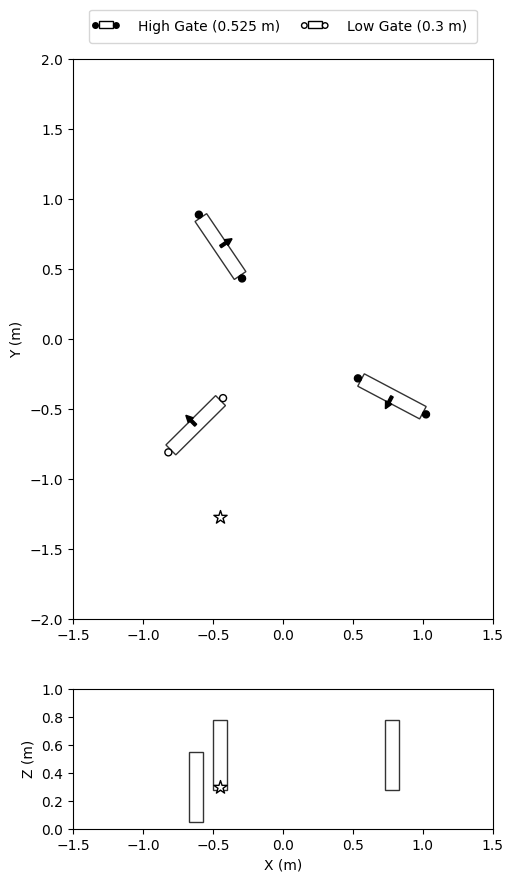

In [16]:
course = np.load(os.path.join(COURSE, "course.npy"))

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)

In [21]:
B = 250
sampler = SamplerType.DDIM
cudnn_benchmark(B, model, vae_downsample, "cuda", sampler)

[ planner ] Warming with cudnn benchmark...
[ planner ] Finished cudnn benchmark


[ 3160305203 ] Considered trajectories from 0


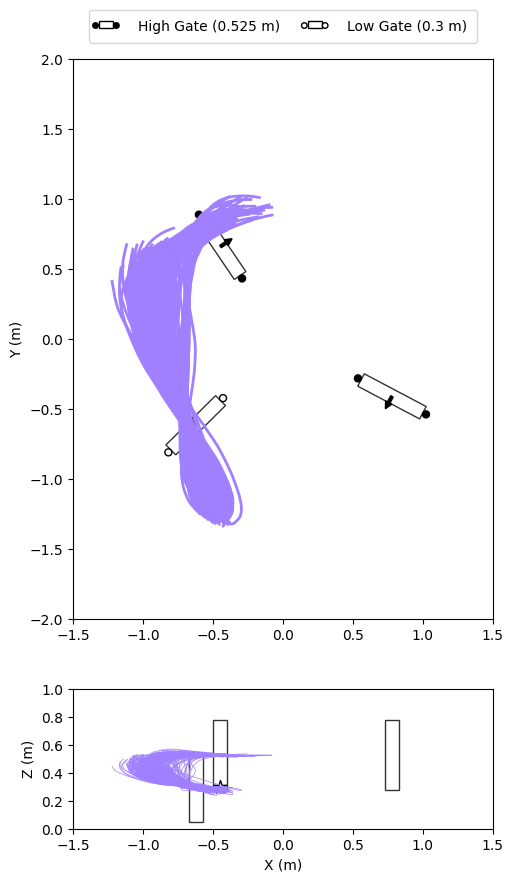

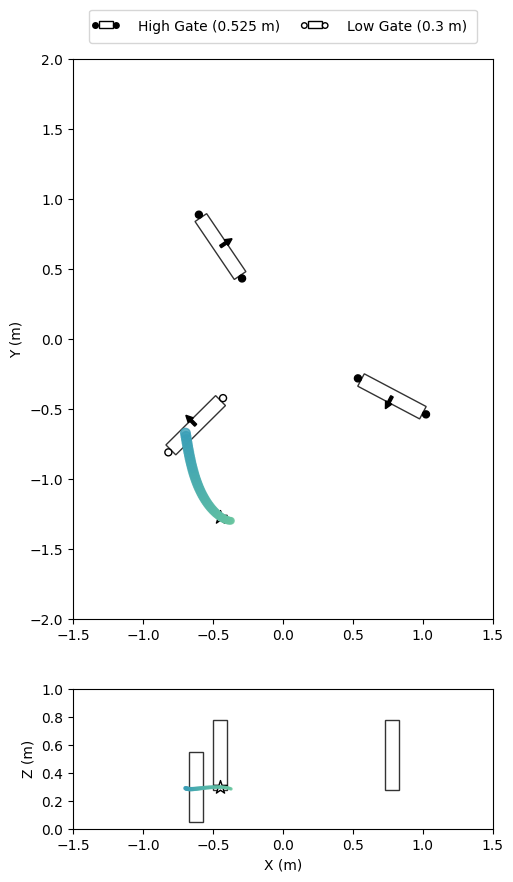

[ 3160305203 ] Considered trajectories from 1


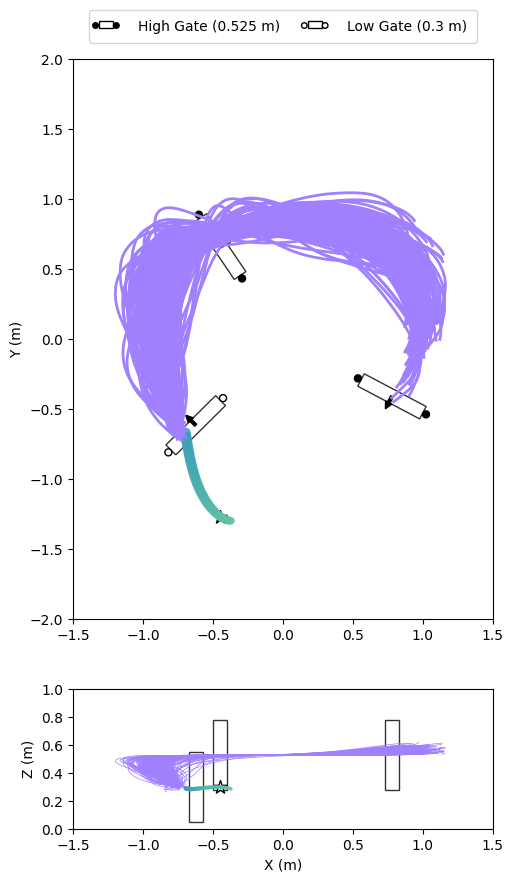

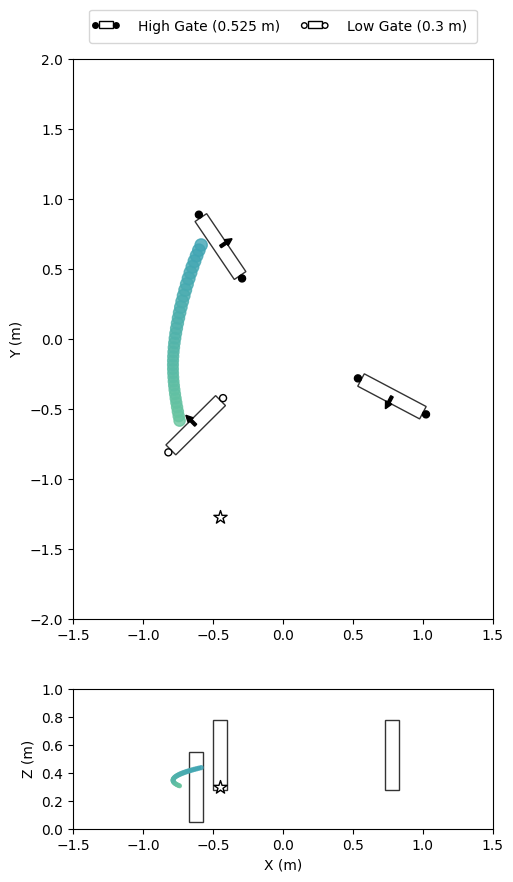

[ 3160305203 ] Considered trajectories from 2


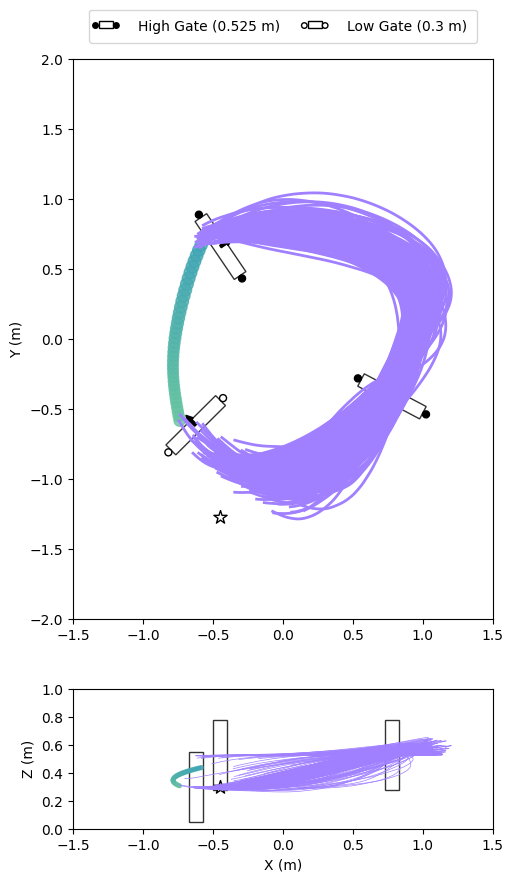

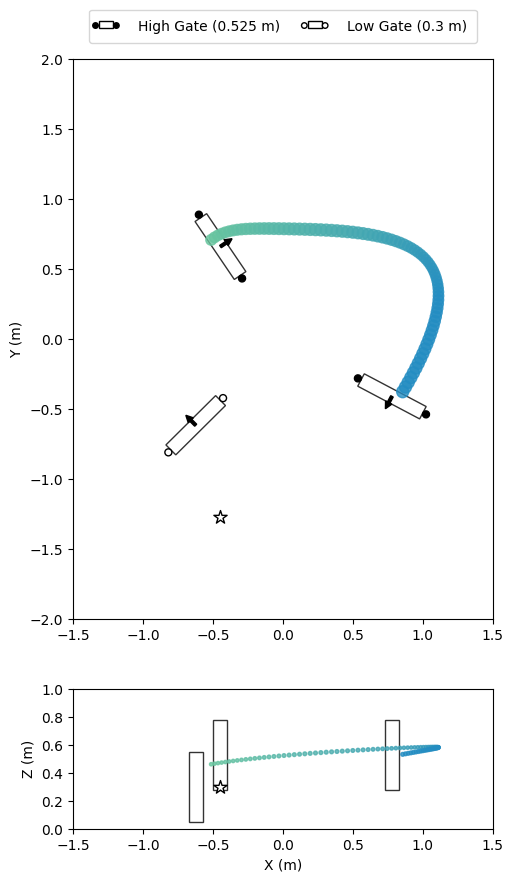

[ 3160305203 ] Considered trajectories from 3


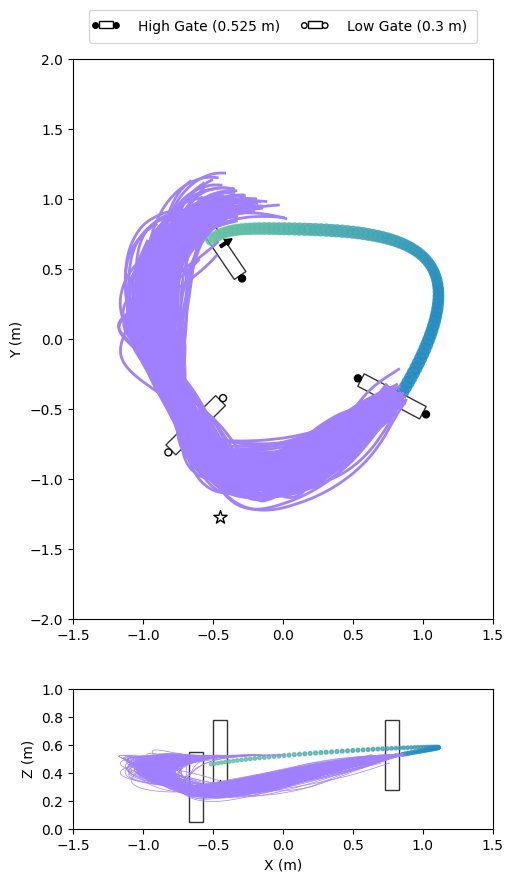

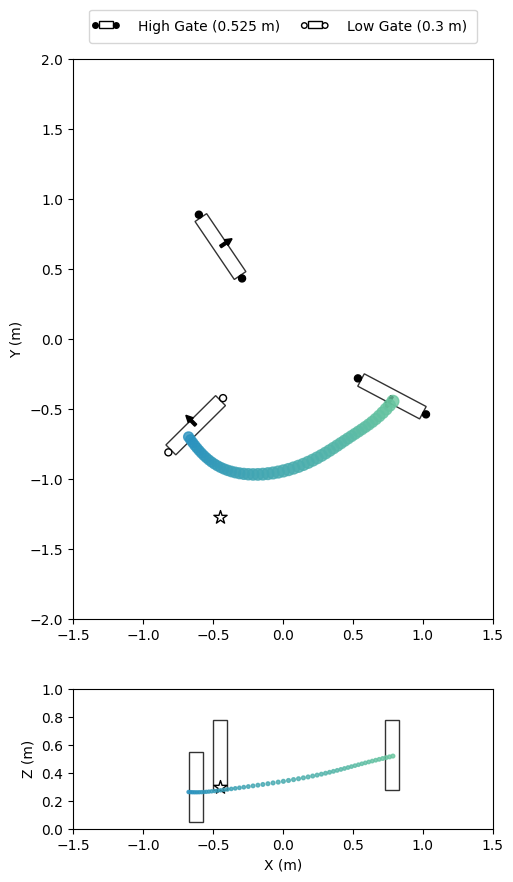

[ 3160305203 ] Considered trajectories from 1


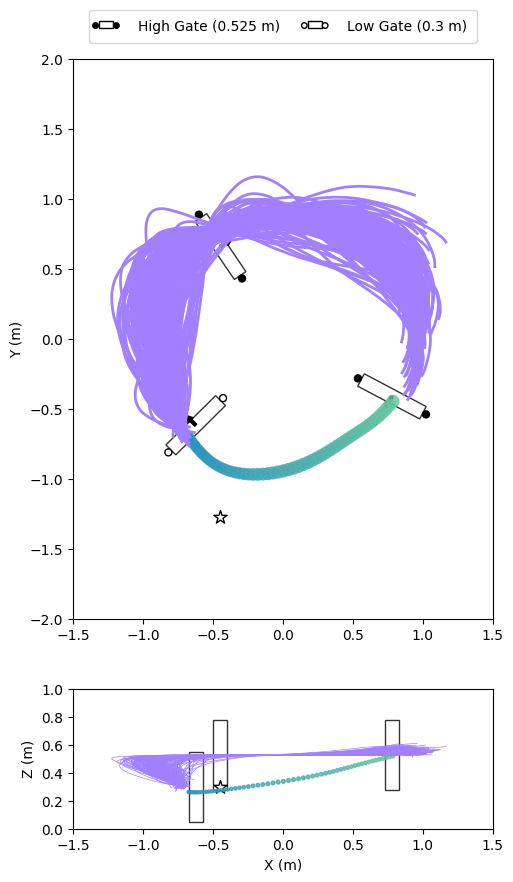

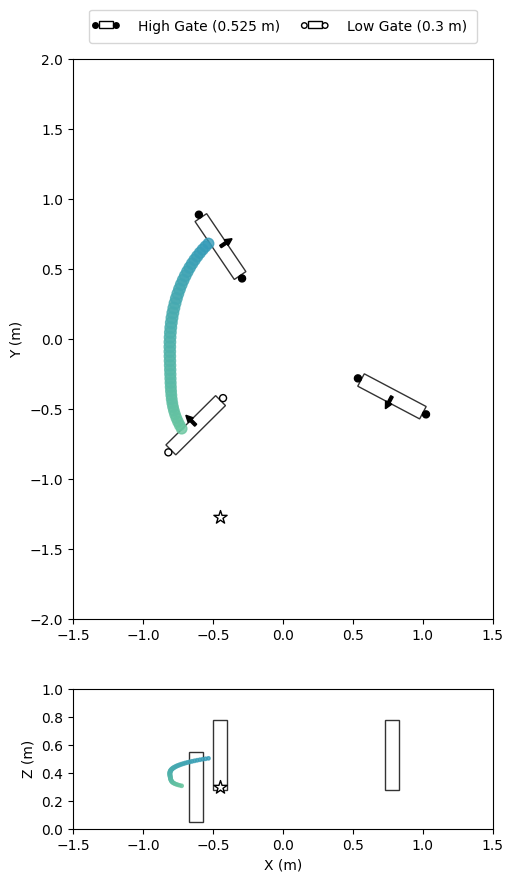

In [24]:
current_traj = None

gate_idx = 0

computation_times = []
trajectory_times = []
trajectories = []

for i in range(5):
    # Provide the full course because the 0th position will be used for creating the local conditioning
    global_context = course
    if current_traj is not None:
        global_context = np.vstack((course[gate_idx + 1:], course[1:gate_idx]))    
    
    s = time.time()
    next_traj, candidates = plan(
        B,
        global_context,
        sampler,
        ScoringMethod.FAST,
        model,
        vae_downsample,
        "cuda",
        current_traj=current_traj
    )
    trajectories.append(next_traj)
    
    computation_times.append(
        time.time() - s
    )
    trajectory_times.append(
        next_traj[0].shape[0] / 30
    )
    
    print(f"Considered trajectories from {gate_idx}")
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    if current_traj:
        add_trajectory_to_course(axs, current_traj[0])
    for traj in candidates:
        add_trajectory_to_course(axs, traj.cpu().numpy(), reference=True)
    plt.show()
    plt.close()
    
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    add_trajectory_to_course(axs, next_traj[0])
    plt.show()
    plt.close()
    
    gate_idx += 1
    current_traj = next_traj
    
    # Looped back around to previous gate
    if gate_idx == len(course):
        gate_idx = 1
    

In [7]:
print(sum(trajectory_times))

[ 2770381850 ] 9.466666666666667


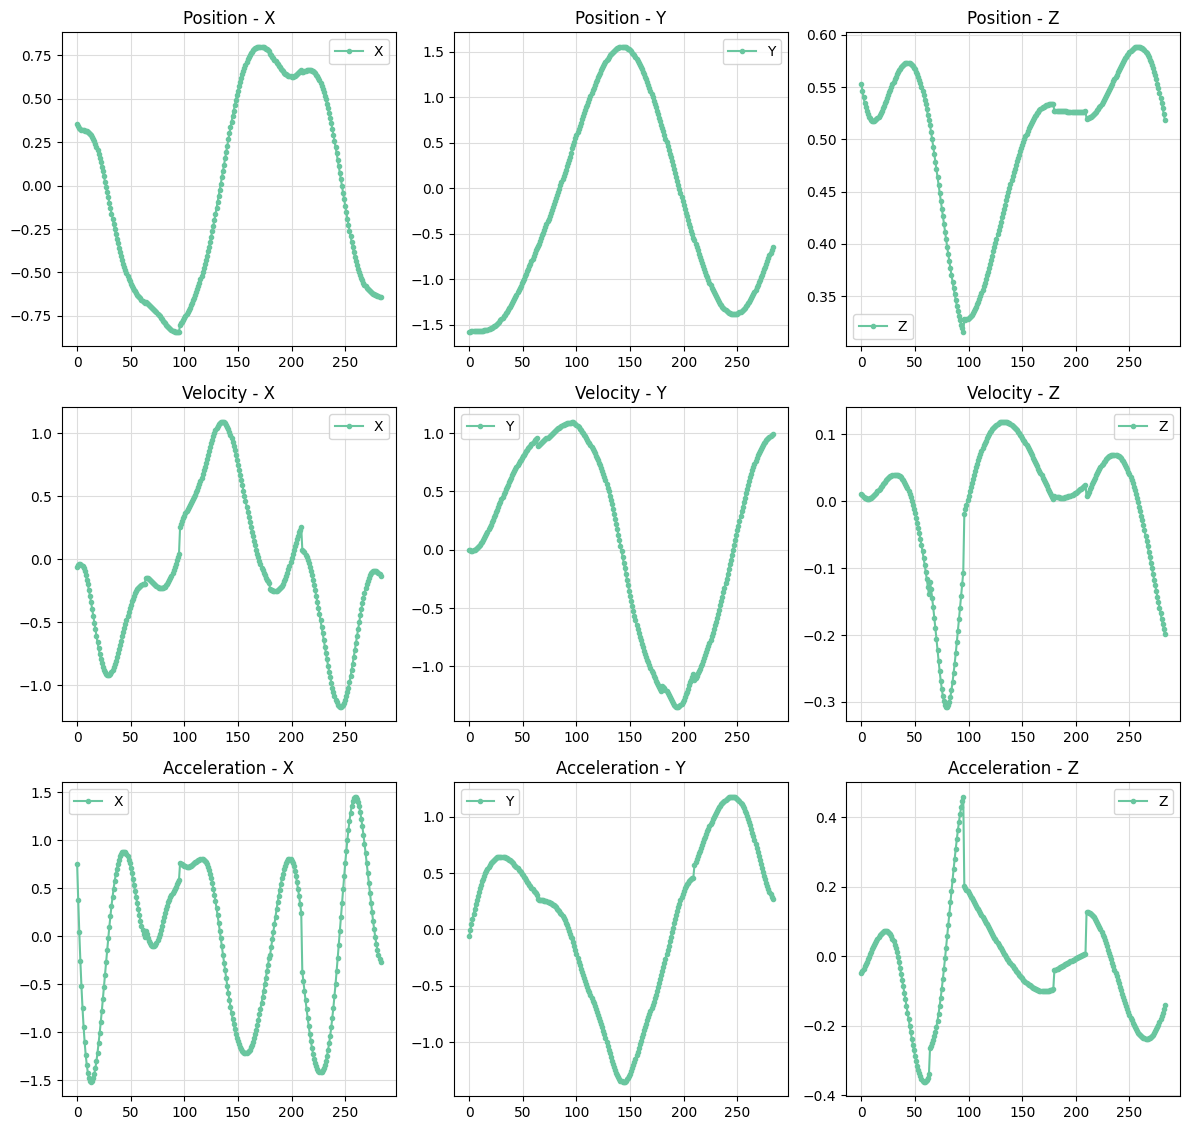

In [8]:
states = [np.vstack([t[idx] for t in trajectories]) for idx in range(3)]
plot_states(*states)

In [9]:
print(computation_times[1:])
print(trajectory_times)

[ 87713355 ] [1.0793795585632324, 1.084216833114624, 1.0822594165802002, 1.0811209678649902]
[ 87713355 ] [2.1333333333333333, 1.0666666666666667, 2.8, 1.0, 2.466666666666667]
